In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "vlim"
z_range = "all_z"
key = "z"
quantile = "1"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  6.61it/s]

14it [00:00,  9.23it/s]

28it [00:00, 12.79it/s]

42it [00:00, 17.55it/s]

54it [00:00, 23.50it/s]

67it [00:00, 31.10it/s]

80it [00:00, 40.27it/s]

94it [00:00, 50.79it/s]

106it [00:01, 60.14it/s]

119it [00:01, 71.59it/s]

131it [00:01, 80.85it/s]

145it [00:01, 91.28it/s]

158it [00:01, 100.00it/s]

171it [00:01, 107.12it/s]

184it [00:01, 112.93it/s]

197it [00:01, 108.31it/s]

209it [00:01, 100.05it/s]

222it [00:01, 107.25it/s]

235it [00:02, 112.94it/s]

248it [00:02, 116.62it/s]

261it [00:02, 116.25it/s]

274it [00:02, 118.98it/s]

287it [00:02, 121.38it/s]

300it [00:02, 118.69it/s]

313it [00:02, 121.27it/s]

327it [00:02, 123.83it/s]

340it [00:02, 122.00it/s]

353it [00:03, 123.89it/s]

366it [00:03, 125.05it/s]

379it [00:03, 114.19it/s]

391it [00:03, 113.56it/s]

405it [00:03, 118.17it/s]

419it [00:03, 121.93it/s]

432it [00:03, 123.56it/s]

445it [00:03, 124.95it/s]

458it [00:03, 121.29it/s]

471it [00:04, 123.47it/s]

485it [00:04, 125.56it/s]

498it [00:04, 122.72it/s]

511it [00:04, 107.12it/s]

523it [00:04, 100.07it/s]

534it [00:04, 98.60it/s] 

547it [00:04, 106.18it/s]

561it [00:04, 112.87it/s]

574it [00:04, 117.22it/s]

587it [00:05, 120.67it/s]

600it [00:05, 111.37it/s]

613it [00:05, 114.20it/s]

626it [00:05, 117.97it/s]

638it [00:05, 116.31it/s]

650it [00:05, 116.01it/s]

663it [00:05, 118.78it/s]

676it [00:05, 121.80it/s]

690it [00:05, 124.31it/s]

704it [00:06, 126.16it/s]

717it [00:06, 126.26it/s]

730it [00:06, 126.09it/s]

743it [00:06, 125.56it/s]

756it [00:06, 116.03it/s]

769it [00:06, 119.05it/s]

782it [00:06, 121.38it/s]

795it [00:06, 123.13it/s]

808it [00:06, 115.40it/s]

820it [00:07, 104.52it/s]

833it [00:07, 110.77it/s]

846it [00:07, 115.89it/s]

858it [00:07, 113.15it/s]

870it [00:07, 114.96it/s]

883it [00:07, 118.87it/s]

896it [00:07, 121.01it/s]

910it [00:07, 123.88it/s]

924it [00:07, 125.76it/s]

938it [00:07, 127.12it/s]

951it [00:08, 127.84it/s]

964it [00:08, 127.50it/s]

977it [00:08, 121.97it/s]

991it [00:08, 124.69it/s]

1004it [00:08, 116.07it/s]

1017it [00:08, 118.99it/s]

1031it [00:08, 121.94it/s]

1044it [00:08, 123.26it/s]

1057it [00:08, 124.69it/s]

1070it [00:09, 104.81it/s]

1082it [00:09, 98.66it/s] 

1093it [00:09, 94.28it/s]

1103it [00:09, 91.39it/s]

1113it [00:09, 89.80it/s]

1123it [00:09, 88.94it/s]

1133it [00:09, 87.13it/s]

1143it [00:09, 89.21it/s]

1156it [00:10, 97.70it/s]

1167it [00:10, 89.48it/s]

1180it [00:10, 98.26it/s]

1193it [00:10, 105.70it/s]

1206it [00:10, 110.13it/s]

1219it [00:10, 113.84it/s]

1231it [00:10, 103.55it/s]

1242it [00:10, 97.03it/s] 

1253it [00:11, 100.20it/s]

1266it [00:11, 106.85it/s]

1279it [00:11, 112.51it/s]

1292it [00:11, 117.07it/s]

1305it [00:11, 120.37it/s]

1318it [00:11, 122.37it/s]

1331it [00:11, 122.77it/s]

1344it [00:11, 116.55it/s]

1357it [00:11, 119.90it/s]

1370it [00:11, 121.77it/s]

1383it [00:12, 123.80it/s]

1396it [00:12, 124.63it/s]

1409it [00:12, 124.16it/s]

1422it [00:12, 121.66it/s]

1435it [00:12, 107.60it/s]

1440it [00:12, 114.35it/s]


0it [00:00, ?it/s]

10it [00:00, 98.78it/s]

Number of empty sat catalogs is 0


23it [00:00, 104.99it/s]

37it [00:00, 112.29it/s]

51it [00:00, 117.67it/s]

64it [00:00, 120.18it/s]

76it [00:00, 118.68it/s]

90it [00:00, 122.99it/s]

104it [00:00, 126.31it/s]

117it [00:00, 126.19it/s]

131it [00:01, 128.66it/s]

145it [00:01, 130.16it/s]

158it [00:01, 124.70it/s]

172it [00:01, 127.47it/s]

186it [00:01, 129.59it/s]

199it [00:01, 127.80it/s]

212it [00:01, 127.72it/s]

226it [00:01, 130.27it/s]

240it [00:01, 132.71it/s]

254it [00:01, 133.28it/s]

268it [00:02, 134.43it/s]

282it [00:02, 135.61it/s]

296it [00:02, 133.64it/s]

310it [00:02, 133.15it/s]

324it [00:02, 132.05it/s]

338it [00:02, 133.69it/s]

352it [00:02, 133.82it/s]

366it [00:02, 134.44it/s]

380it [00:02, 134.05it/s]

394it [00:03, 134.27it/s]

408it [00:03, 133.43it/s]

422it [00:03, 134.55it/s]

436it [00:03, 115.97it/s]

450it [00:03, 121.64it/s]

464it [00:03, 125.09it/s]

478it [00:03, 128.36it/s]

492it [00:03, 130.53it/s]

506it [00:03, 132.89it/s]

520it [00:04, 131.85it/s]

534it [00:04, 127.56it/s]

548it [00:04, 128.32it/s]

561it [00:04, 128.04it/s]

575it [00:04, 130.47it/s]

589it [00:04, 131.61it/s]

603it [00:04, 111.84it/s]

615it [00:04, 107.07it/s]

629it [00:04, 114.52it/s]

644it [00:05, 121.21it/s]

658it [00:05, 125.56it/s]

672it [00:05, 129.14it/s]

686it [00:05, 132.04it/s]

700it [00:05, 133.33it/s]

714it [00:05, 134.71it/s]

728it [00:05, 134.14it/s]

742it [00:05, 134.91it/s]

756it [00:05, 135.27it/s]

770it [00:05, 125.73it/s]

783it [00:06, 125.02it/s]

797it [00:06, 128.07it/s]

810it [00:06, 127.78it/s]

824it [00:06, 129.60it/s]

838it [00:06, 132.27it/s]

852it [00:06, 134.11it/s]

866it [00:06, 134.85it/s]

880it [00:06, 135.65it/s]

894it [00:06, 134.39it/s]

908it [00:07, 134.03it/s]

922it [00:07, 134.92it/s]

936it [00:07, 120.75it/s]

950it [00:07, 124.66it/s]

964it [00:07, 127.58it/s]

978it [00:07, 130.29it/s]

992it [00:07, 131.84it/s]

1006it [00:07, 131.37it/s]

1020it [00:07, 132.40it/s]

1034it [00:08, 130.68it/s]

1048it [00:08, 131.50it/s]

1062it [00:08, 132.77it/s]

1076it [00:08, 132.97it/s]

1090it [00:08, 133.85it/s]

1104it [00:08, 134.04it/s]

1118it [00:08, 130.50it/s]

1132it [00:08, 132.65it/s]

1146it [00:08, 114.07it/s]

1160it [00:09, 119.17it/s]

1174it [00:09, 124.62it/s]

1188it [00:09, 127.78it/s]

1202it [00:09, 131.18it/s]

1217it [00:09, 133.27it/s]

1231it [00:09, 133.10it/s]

1245it [00:09, 132.04it/s]

1259it [00:09, 133.16it/s]

1273it [00:09, 134.01it/s]

1287it [00:09, 130.24it/s]

1301it [00:10, 132.16it/s]

1315it [00:10, 132.80it/s]

1329it [00:10, 134.00it/s]

1343it [00:10, 134.15it/s]

1357it [00:10, 121.85it/s]

1371it [00:10, 125.46it/s]

1385it [00:10, 128.22it/s]

1399it [00:10, 130.18it/s]

1413it [00:10, 131.51it/s]

1427it [00:11, 132.44it/s]

1440it [00:11, 129.43it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

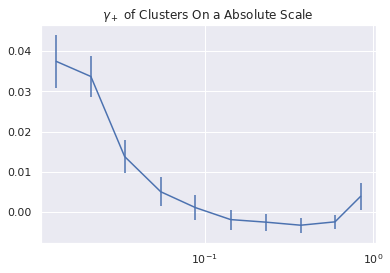

Aggregated xi:
[ -9.1015 -19.3826 -12.4295  -7.1806  -2.7916   6.8106  13.9393  24.1105
  19.7761 -10.6596]
------------------------------------------------------------------------------
Aggregated meanlogr:
[-1052.8037 -2219.1345 -3050.6921 -4087.6432 -5862.451  -7304.9712
 -8319.5058 -7418.9405 -4314.8321  -448.3496]
------------------------------------------------------------------------------
Aggregated npairs:
[ 243.  575.  898. 1408. 2415. 3754. 5687. 7513. 8334. 2689.]
------------------------------------------------------------------------------
Mean xi:
[-0.0375 -0.0337 -0.0138 -0.0051 -0.0012  0.0018  0.0025  0.0032  0.0024
 -0.004 ]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3325 -3.8594 -3.3972 -2.9032 -2.4275 -1.9459 -1.4629 -0.9875 -0.5177
 -0.1667]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

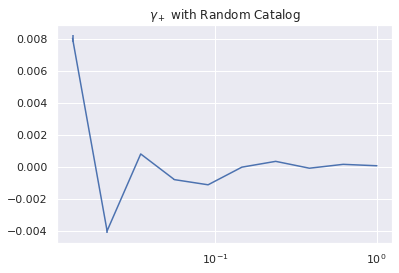

[ 8.0614e-03 -4.0169e-03  8.0985e-04 -8.0003e-04 -1.1234e-03 -1.6914e-05
  3.4635e-04 -8.3508e-05  1.5886e-04  6.9678e-05]
[-2.1244e-04  1.0585e-04 -2.1341e-05  2.1083e-05  2.9603e-05  4.4573e-07
 -9.1272e-06  2.2006e-06 -4.1863e-06 -1.8362e-06]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

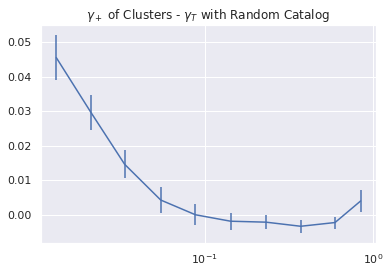

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

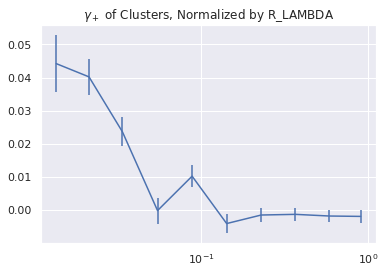

Aggregated xi:
[ -6.4984 -15.3565 -18.0115   0.281  -18.8702  12.7198   7.4      9.2167
  15.6161  13.744 ]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -633.2317 -1472.7501 -2592.7248 -3210.7145 -4515.5591 -5941.6628
 -6837.5141 -6614.1336 -4370.7178  -683.8237]
------------------------------------------------------------------------------
Aggregated npairs:
[ 147.  382.  764. 1104. 1858. 3043. 4636. 6596. 8214. 6816.]
------------------------------------------------------------------------------
Mean xi:
[-0.0442 -0.0402 -0.0236  0.0003 -0.0102  0.0042  0.0016  0.0014  0.0019
  0.002 ]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3077 -3.8554 -3.3936 -2.9083 -2.4303 -1.9526 -1.4749 -1.0027 -0.5321
 -0.1003]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)